In [1069]:

from experiment_information import *
from data import *
from util import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as np
import numpy as np
import logging
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1070]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

def explode_calibrations(df):
    a = df["calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["calibrations"])
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["calibrations","ps"])
    # rename the exploded columns
    df = df.rename(columns={"calibrations":"calibration","ps":"p"})
    return df
df_state_evolution = explode_calibrations(df_state_evolution)
def explode_erm_calibrations(df):
    a = df["erm_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["erm_calibrations"])
    b = df["analytical_calibrations"].apply(pd.Series)
    # drop the original calibrations column
    df = df.drop(columns=["analytical_calibrations"])
    # drop the dp and ps columns from b
    b = b.drop(columns=["dp","ps"])
    # rename the columns of b
    b = b.rename(columns={"calibrations":"analytical_calibration"})
    # rename the columns of a
    a = a.rename(columns={"calibrations":"erm_calibration"})
    # concat the original dataframe with the new dataframe containing the exploded calibrations column
    df = pd.concat([df,a],axis=1)
    df = pd.concat([df,b],axis=1)
    # explode both calibrations and ps columns
    df = df.explode(["erm_calibration","analytical_calibration","ps"])
    # rename the exploded columns
    df = df.rename(columns={"ps":"p"})
    return df
df_erm = explode_erm_calibrations(df_erm)
print("Current code version, ", __version__)

Current code version,  50


In [1071]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
# version_choice = "42"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(20)

,experiment_id,experiment_name,duration,code_version,date,state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,ps,dp,d,erm_methods,completed
64,83400e5c-9bb1-4001-9377-9dcfc8439b39,Default Experiment,695.696055,50,2023-05-21 15:37:29,1,0,"[0.15848931924611134, 0.2960932939627083, 0.55...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
63,26dbec2d-8e4a-4476-be51-e25014c5654a,Default Experiment,1253.721581,50,2023-05-21 15:06:59,1,0,"[0.15848931924611134, 0.2960932939627083, 0.55...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
60,bf9f5279-6a2a-4e1a-a4ef-1f6b213d6714,Default Experiment,97.371676,50,2023-05-21 14:30:19,1,0,"[0.15848931924611134, 0.41142029787528417, 1.0...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
59,bf62440f-492f-40f4-a8b8-c9d844a8664b,Default Experiment,667.026218,50,2023-05-21 14:10:46,1,3,"[0.15848931924611134, 0.5956621435290104, 2.23...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
58,f0103d78-e5ef-4fed-909e-34389a81d662,Default Experiment,97.051350,50,2023-05-21 14:06:46,1,0,"[0.15848931924611134, 0.41142029787528417, 1.0...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
56,d308a352-7d65-4cc4-8fa7-13cf86e2cf46,Default Experiment,624.686929,50,2023-05-21 13:53:24,1,0,"[0.15848931924611134, 0.41142029787528417, 1.0...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
55,5d8792a8-a0a7-4619-9f55-6db351dcb7b3,Default Experiment,229.685336,50,2023-05-21 13:38:16,1,0,"[0.15848931924611134, 0.41142029787528417, 1.0...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
50,8b59f67a-b290-49df-a6f8-5a6a80775ade,Default Experiment,579.451224,50,2023-05-21 12:14:52,1,0,"[0.15848931924611134, 0.2960932939627083, 0.55...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
48,a1034de4-55e9-4717-84d9-cc0758644f06,Default Experiment,0.911385,50,2023-05-21 12:10:37,1,0,"[0.15848931924611134, 0.2960932939627083, 0.55...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1
47,d3d0c004-9d0b-4fac-995b-dd125f4d73e8,Default Experiment,0.956358,50,2023-05-21 12:10:26,1,0,"[0.15848931924611134, 0.2960932939627083, 0.55...","[0.0, 0.25, 0.5, 0.75, 1.0]","[0.01, 1.0]","[0.1, 0.9]",[0.75],0.01,700,"[""sklearn""]",1


In [1072]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [1073]:
# extract and print the top experiment_id
experiment_id = df_experiments.iloc[0]["experiment_id"]
print(experiment_id)
# experiment_id = "031d5eb9-bf79-4ffb-9fb3-eabedcd350b0"

# This guy was interesting in version 25 for the q- state evolution adaptation
# a2a3016c-8264-4599-ac8f-b457da2790ba
# this guy is interesting in version 28! q-state evolution - best erm so far, close call
# b5f9faf7-ec66-490c-ac99-841888f3fedf
# experiment_id = "b5f9faf7-ec66-490c-ac99-841888f3fedf"
# version 30: 7b921b61-0b48-48a8-8ead-78bc5804597f - q state evolution. Overlaps match except for lambda = 1 in the settings tau=0,2, lam=5*1e-5 for epsilon up to 0.7
# version 30: f92b13d1-c020-46c0-a3cd-5e0578b831a5 - Q state evolution. Same setting as above but not matching overlap.

# version 36 on cluster: 58b544ab-3536-4eb7-bbb9-743f471f6bb3

83400e5c-9bb1-4001-9377-9dcfc8439b39


In [1074]:
round_to = 1
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
# ceil the alpha values to 1 decimal
state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,round_to))
erm = df_erm[df_erm["experiment_id" ] == experiment_id]
# gd = erm[erm["chosen_minimizer"] == "gd"]
# gd = erm[erm["chosen_minimizer"] == "L-BFGS-B"]
# gd = erm[erm["chosen_minimizer"] == "logistic"]
gd = erm[erm["chosen_minimizer"] == "sklearn"]
# ceil the alpha values to 1 decimal
gd["alpha"] = gd["alpha"].apply(lambda x: round(x,round_to))
# set alpha, epsilon, tau, lam as index in gd and state_evolution
gd = gd.set_index(["alpha","epsilon","tau","lam","p"])
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","p"])
# from state_evolution keep generalization_error, sigma, q, m, cosb
state_evolution = state_evolution[["generalization_error","sigma","q","m","cosb","training_loss","calibration","estimation_error","sigma_hat","q_hat","m_hat","adversarial_generalization_error","training_error"]]
# add a suffix _state_evolution to the columns
state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
# from gd keep generalization_error_erm	generalization_error_overlap Q	rho	m	cosb
gd = gd[["generalization_error_erm","generalization_error_overlap","Q","rho","m","cosb", "training_error","d", "training_loss","erm_calibration","analytical_calibration","test_loss","adversarial_generalization_error_erm","adversarial_generalization_error_overlap"]]
# add a suffix _erm to the columns
gd.columns = [col+"_erm" for col in gd.columns]
# join the two dataframes (if a value is missing in one of the two dataframes, it is filled with NaN)
df = state_evolution.join(gd, how="outer")
# reorder the columns
df = df[['generalization_error_state_evolution', 'generalization_error_erm_erm', 'generalization_error_overlap_erm', 'sigma_state_evolution', 'q_state_evolution','Q_erm','m_state_evolution','m_erm','cosb_state_evolution','cosb_erm', 'rho_erm',"training_loss_state_evolution","training_loss_erm","training_error_erm","d_erm","erm_calibration_erm","analytical_calibration_erm","calibration_state_evolution","test_loss_erm","estimation_error_state_evolution","sigma_hat_state_evolution","q_hat_state_evolution","m_hat_state_evolution","adversarial_generalization_error_state_evolution","adversarial_generalization_error_overlap_erm","adversarial_generalization_error_erm_erm","training_error_state_evolution"]]
# average all quantities over the index and obtain also the standard deviation
df = df.groupby(level=[0,1,2,3,4]).agg([np.mean,np.std])
# display all columns
# pd.set_option('display.max_columns', None)
# # display all rows
# pd.set_option('display.max_rows', None)
df

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_21815/149269820.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["alpha"] = state_evolution["alpha"].apply(lambda x: round(x,round_to))


generalization_error_state_evolution      \
                                                             mean std   
alpha  epsilon tau lam  p                                               
0.2    0.00    0.1 0.01 0.75                             0.400296 NaN   
                   1.00 0.75                             0.401585 NaN   
               0.9 0.01 0.75                             0.445621 NaN   
                   1.00 0.75                             0.444965 NaN   
       0.25    0.1 0.01 0.75                             0.400328 NaN   
...                                                           ...  ..   
1000.0 0.75    0.9 0.01 0.75                             0.233654 NaN   
                   1.00 0.75                             0.233645 NaN   
       1.00    0.1 1.00 0.75                             0.033399 NaN   
               0.9 0.01 0.75                             0.233667 NaN   
                   1.00 0.75                             0.233666 NaN   

                             generalization_error_erm_erm      \
                                                     mean std   
alpha  epsilon tau lam  p                                       
0.2    0.00    0.1 0.01 0.75                          NaN NaN   
                   1.00 0.75                          NaN NaN   
               0.9 0.01 0.75                          NaN NaN   
                   1.00 0.75                          NaN NaN   
       0.25    0.1 0.01 0.75                          NaN NaN   
...                                                   ...  ..   
1000.0 0.75    0.9 0.01 0.75                          NaN NaN   
                   1.00 0.75                          NaN NaN   
       1.00    0.1 1.00 0.75                          NaN NaN   
               0.9 0.01 0.75                          NaN NaN   
                   1.00 0.75                          NaN NaN   

                             generalization_error_overlap_erm      \
                                                         mean std   
alpha  epsilon tau lam  p                                           
0.2    0.00    0.1 0.01 0.75                              NaN NaN   
                   1.00 0.75                              NaN NaN   
               0.9 0.01 0.75                              NaN NaN   
                   1.00 0.75                              NaN NaN   
       0.25    0.1 0.01 0.75                              NaN NaN   
...                                                       ...  ..   
1000.0 0.75    0.9 0.01 0.75                              NaN NaN   
                   1.00 0.75                              NaN NaN   
       1.00    0.1 1.00 0.75                              NaN NaN   
               0.9 0.01 0.75                              NaN NaN   
                   1.00 0.75                              NaN NaN   

                             sigma_state_evolution     q_state_evolution      \
                                              mean std              mean std   
alpha  epsilon tau lam  p                                                      
0.2    0.00    0.1 0.01 0.75             88.401842 NaN      1.794544e+00 NaN   
                   1.00 0.75              0.970242 NaN      2.597312e-02 NaN   
               0.9 0.01 0.75             88.304085 NaN      1.838746e+00 NaN   
                   1.00 0.75              0.970175 NaN      2.529794e-02 NaN   
       0.25    0.1 0.01 0.75             88.184747 NaN      2.111814e+00 NaN   
...                                            ...  ..               ...  ..   
1000.0 0.75    0.9 0.01 0.75              6.840830 NaN      1.243573e+07 NaN   
                   1.00 0.75              0.069329 NaN      1.275192e+03 NaN   
       1.00    0.1 1.00 0.75              0.390390 NaN      9.616656e+04 NaN   
               0.9 0.01 0.75             24.210160 NaN      1.795106e+08 NaN   
                   1.00 0.75              0.242128 NaN      1.795322e+04 NaN   

       

In [1075]:
def extract_optimal_lambda(alpha, epsilon, tau, recursion_depth = 0):
    # extract or compute optimal lamba and plot it as a vertical line
    filename = f"optimal_lambdas.csv"
    # read filename as pandas dataframe
    df_optimal_lambdas = pd.read_csv(filename)
    # filter the dataframe for the current value of tau, epsilon and alpha
    optimal_lambdas_subset = df_optimal_lambdas[(df_optimal_lambdas["tau"] == tau) & (df_optimal_lambdas["epsilon"] == epsilon) & (df_optimal_lambdas["alpha"] == alpha)]
    # extract the optimal lambda
    try:
        optimal_lambda = optimal_lambdas_subset["lambda"].values[0]
        return optimal_lambda
    except:
        if recursion_depth > 0:
            return None
        print("Optimal lambda not found. Computing it now.")
        command = f"python optimal_choice.py {alpha} {epsilon} {tau}"
        import subprocess
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        process.wait()
        return extract_optimal_lambda(alpha,epsilon,tau,recursion_depth=recursion_depth+1)

In [1076]:
first_iteration = "tau"
second_iteration = "lam"
target = "alpha"
sweep = "epsilon"
def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None):
    df2 = df.reset_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    for tau in df2[first_iteration].unique():
        for lam in df2[second_iteration].unique():

            # Filter the dataframe for the current values of tau and lam
            data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam)]

            if fix_a_variable is not None:
                data = data[data[fix_a_variable] == variable_value]
            
            for i, epsilon in enumerate(data[sweep].unique()):
                # Filter the dataframe for the current value of epsilon
                epsilon_subset = data[data[sweep] == epsilon]

                # Plot the state_evolution results as a line
                if state_evolution_name is not None:
                    plt.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep}: {epsilon}', color=palette[i])
                
                # Plot the gradient_descent results as points with error bars
                if gd_name is not None:
                    try:
                        plt.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                    except:
                        pass

                if error_name == "Generalization Error" and target == "lam":
                    optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau)
                    # plot the optimal lambda as a vertical line
                    plt.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

            
            if log_x:
                plt.xscale('log')
            if log_y:
                plt.yscale('log')

            # Add labels and title
            plt.xlabel(target)
            plt.ylabel(error_name)
            if fix_a_variable is not None:
                plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d} - {fix_a_variable}: {variable_value}')
            else:
                plt.title(f'{error_name} - {first_iteration}: {tau}, {second_iteration}: {lam}, d: {d}')
            # Add a legend
            plt.legend()

            # add a grid
            plt.grid()
            if fix_a_variable is not None:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
            else:
                name = f"{error_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
            # Save the plot as svg
            plt.savefig(f"Assets/{name}.svg")

            # Show the plot
            plt.show()

In [1077]:
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=1.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=2.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=5.0)
# create_plot(df, "Calibration", "calibration_state_evolution","erm_calibration_erm",fix_a_variable="alpha", variable_value=15.0)

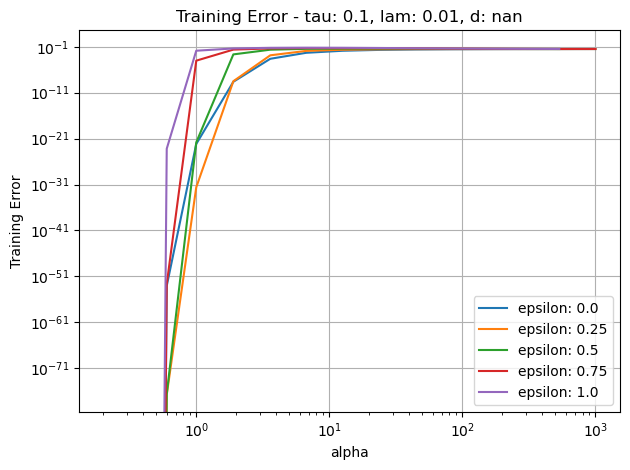

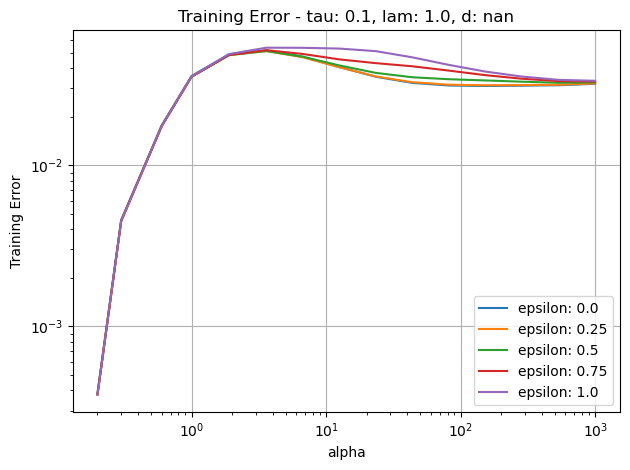

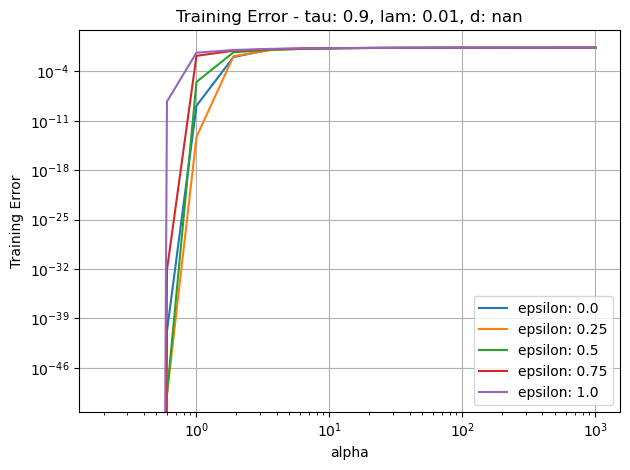

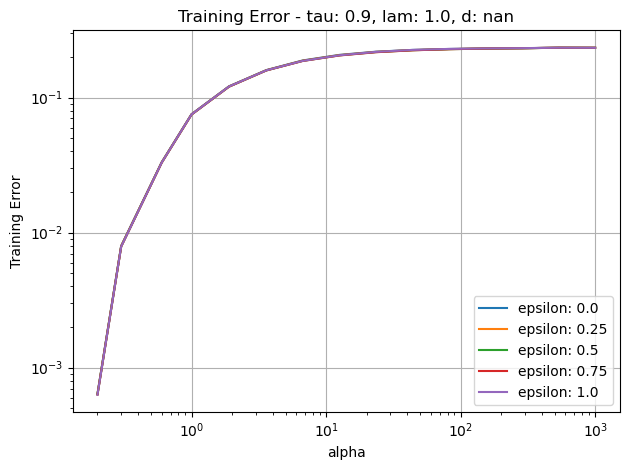

In [1078]:
# plot the erm training error
create_plot(df, "Training Error", "training_error_state_evolution","training_error_erm")

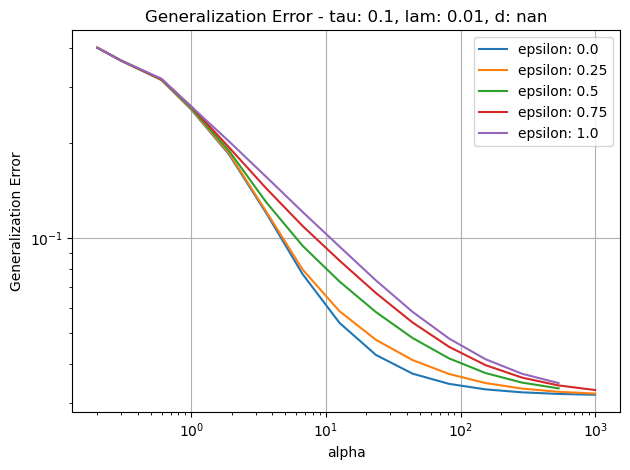

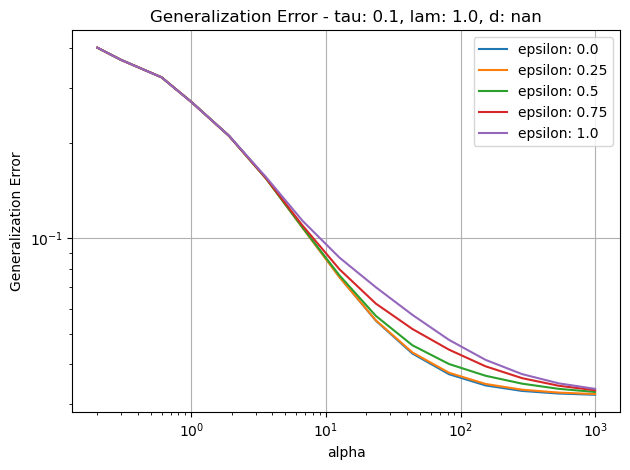

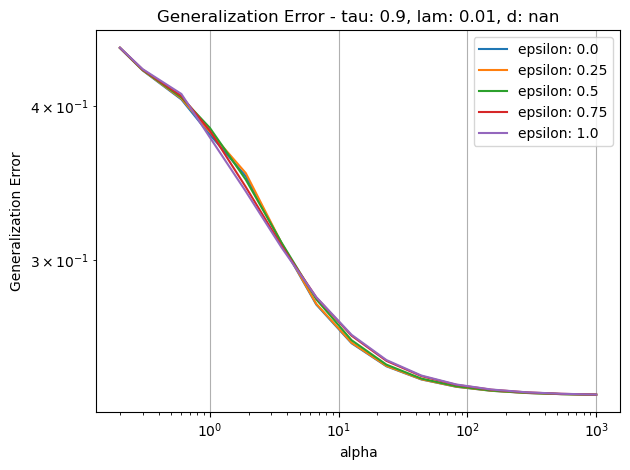

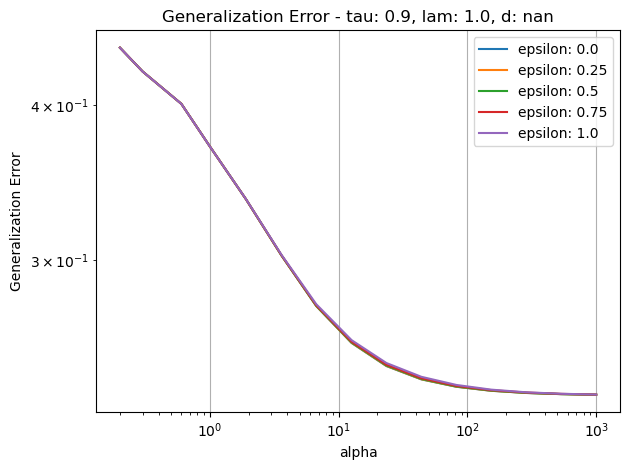

In [1079]:
create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm")

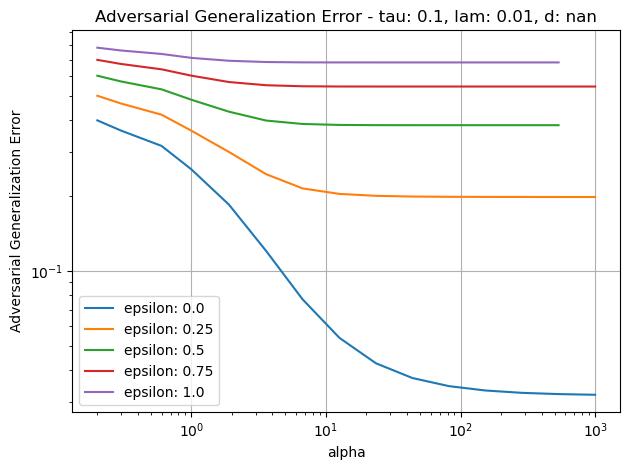

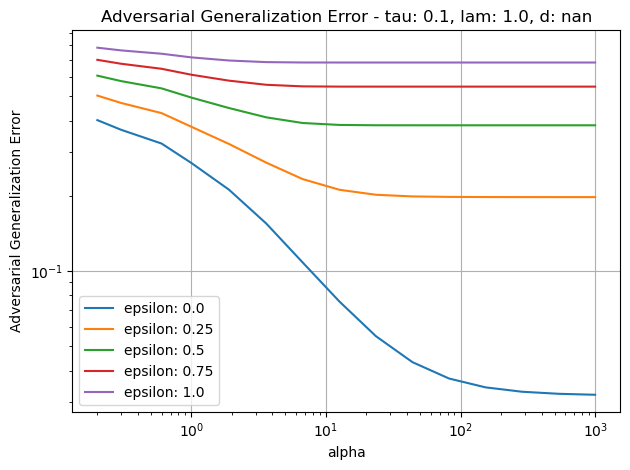

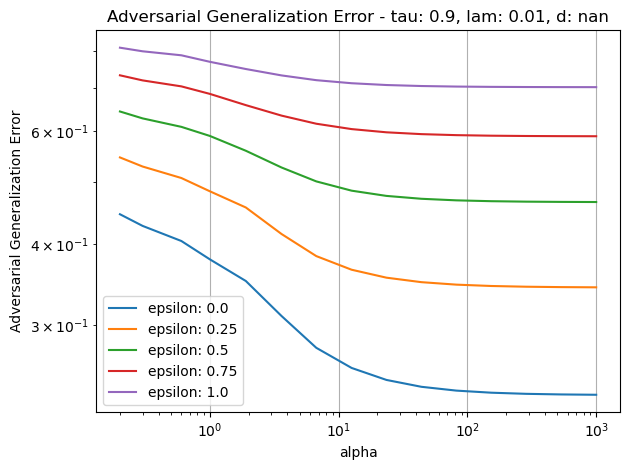

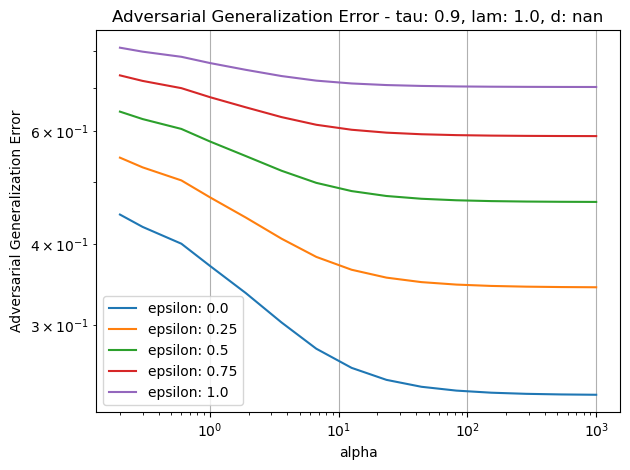

In [1080]:
create_plot(df, "Adversarial Generalization Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm_erm")

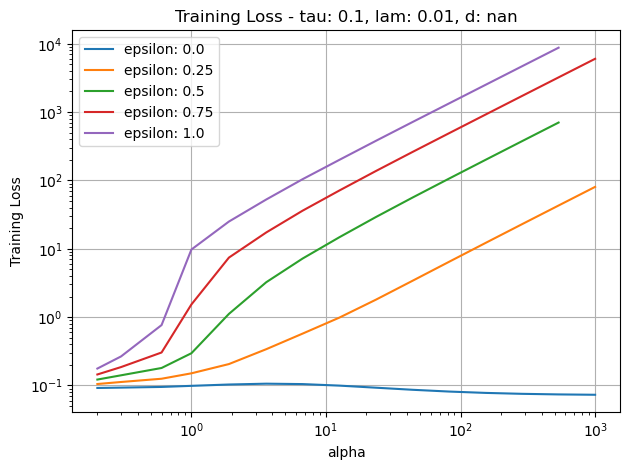

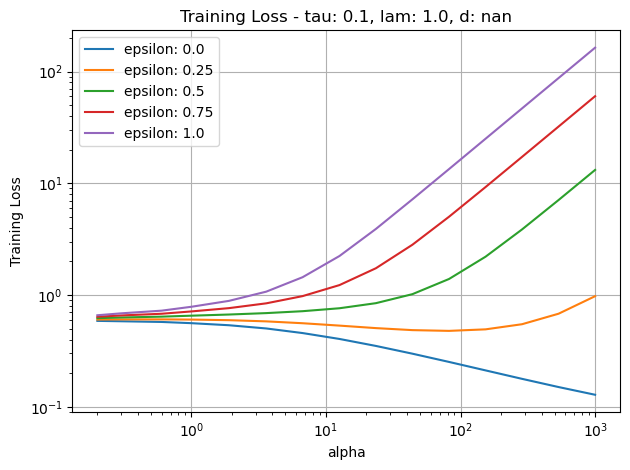

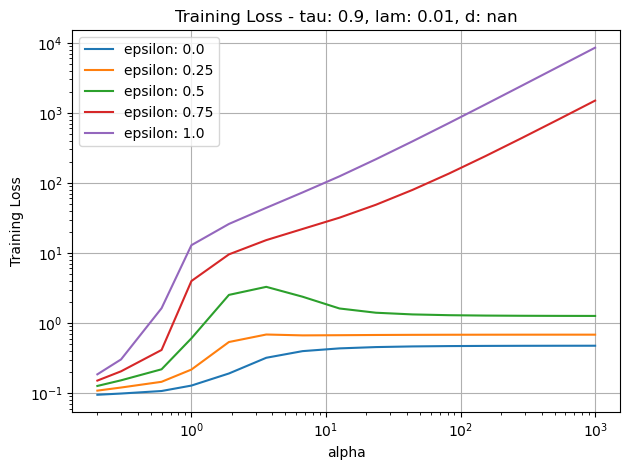

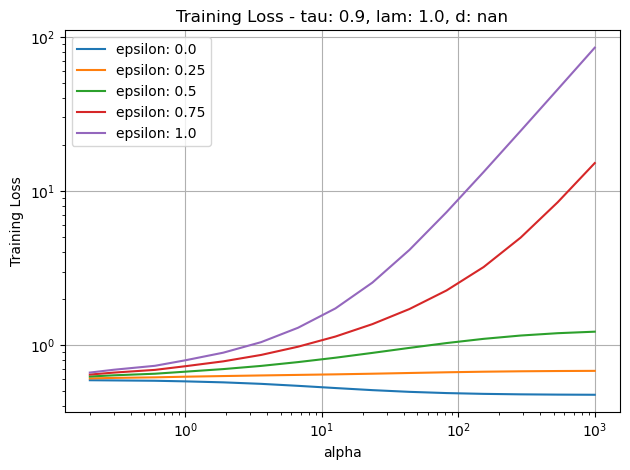

In [1081]:
create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

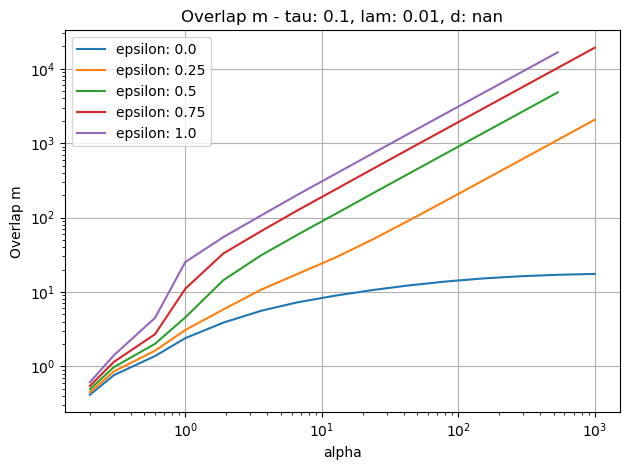

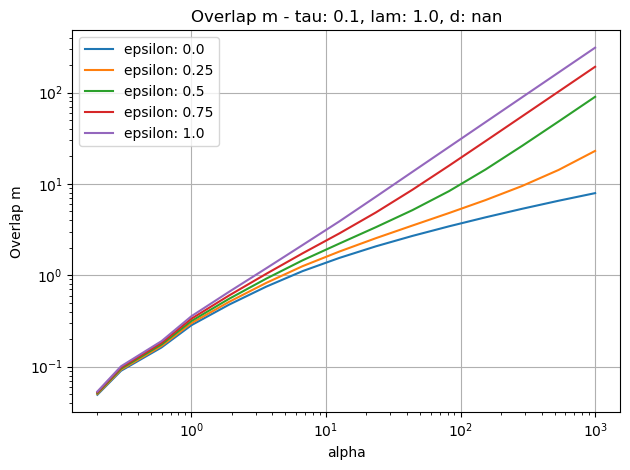

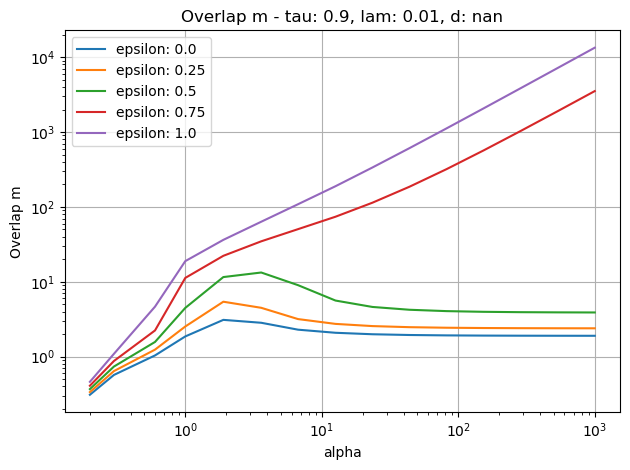

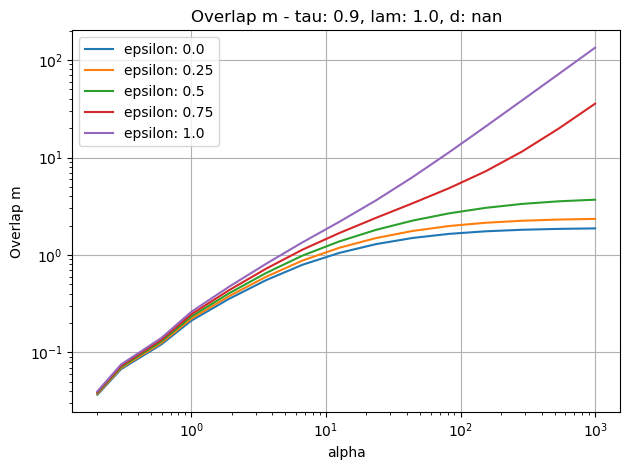

In [1082]:
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_y=True)

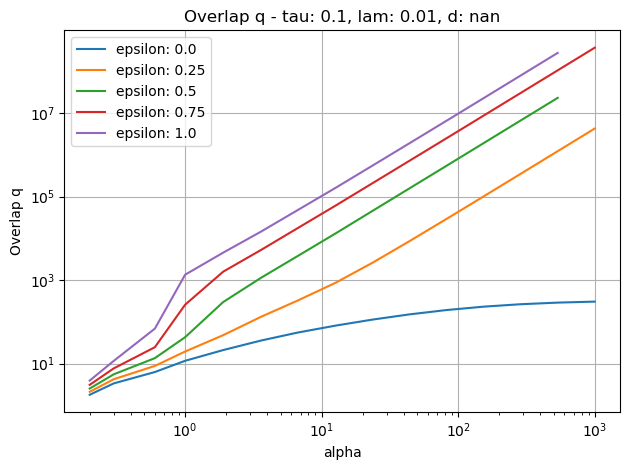

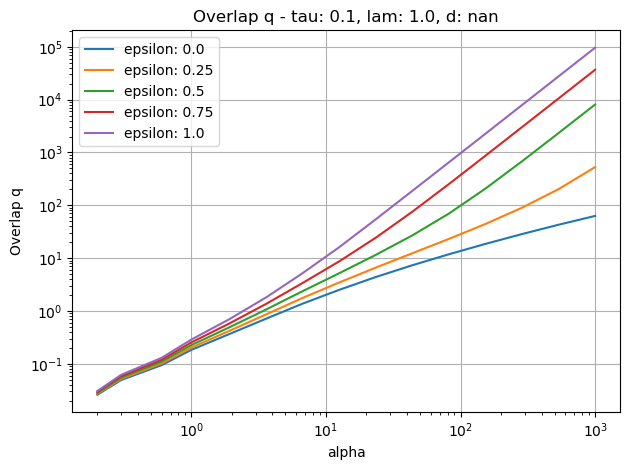

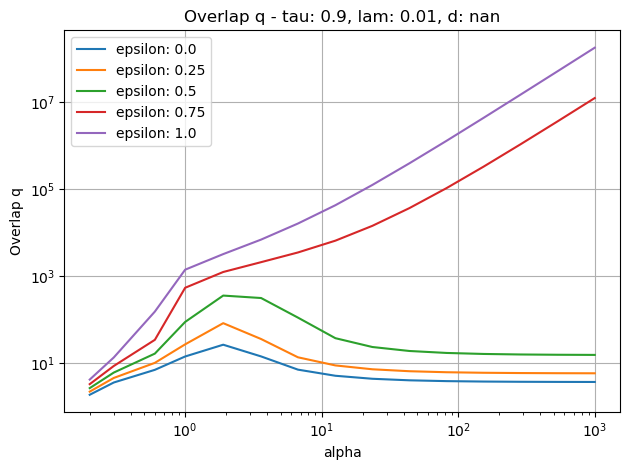

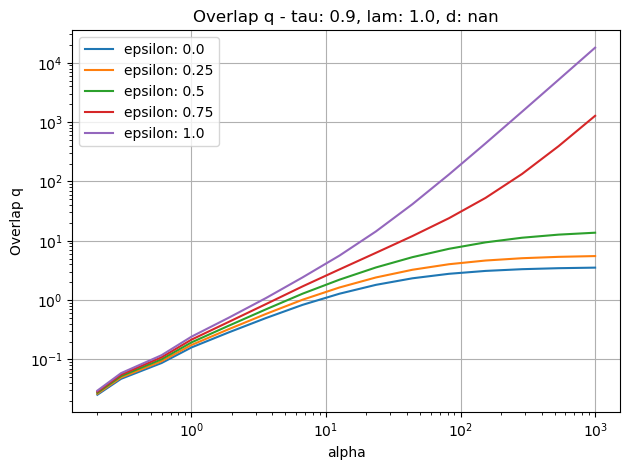

In [1083]:
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_y=True)

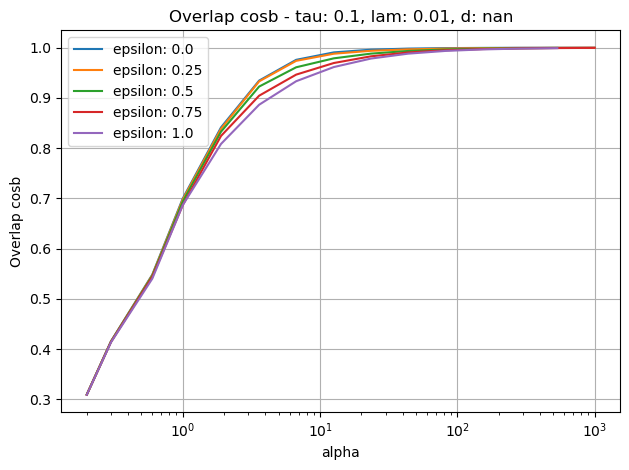

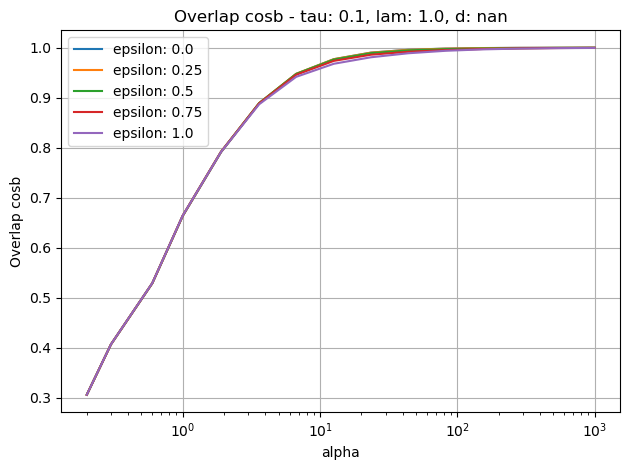

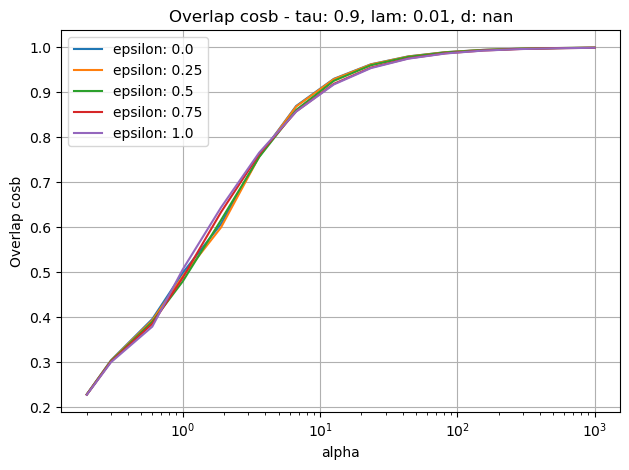

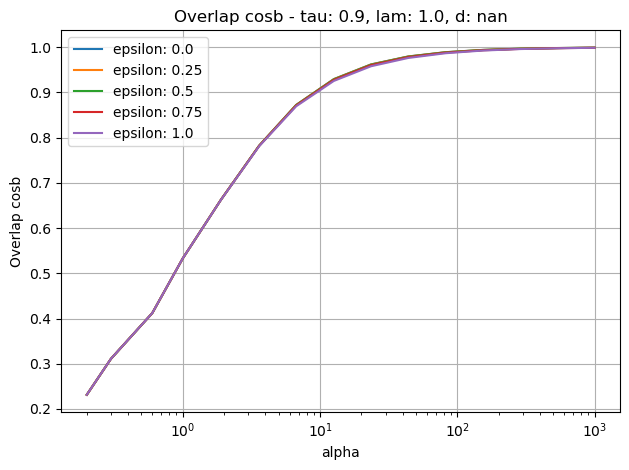

In [1084]:
create_plot(df, "Overlap cosb", "cosb_state_evolution","cosb_erm",log_y=False)

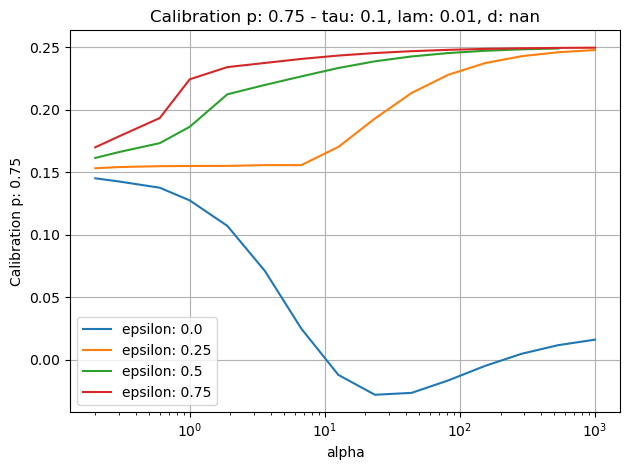

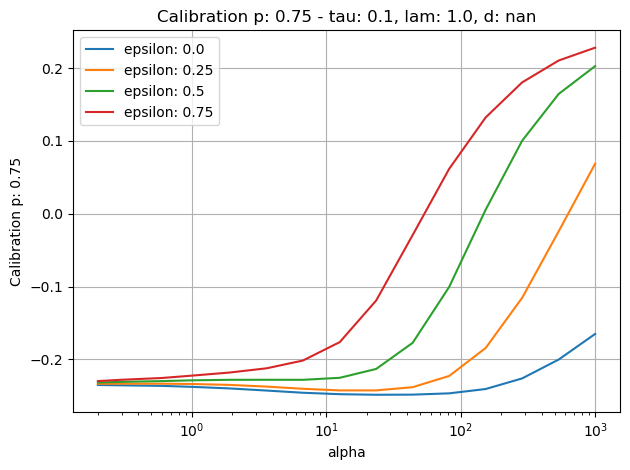

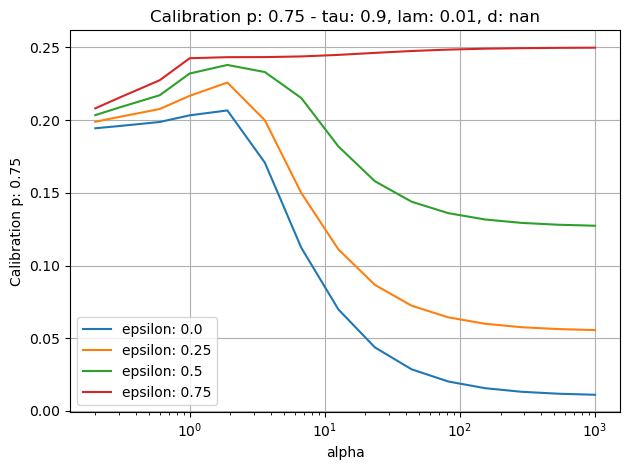

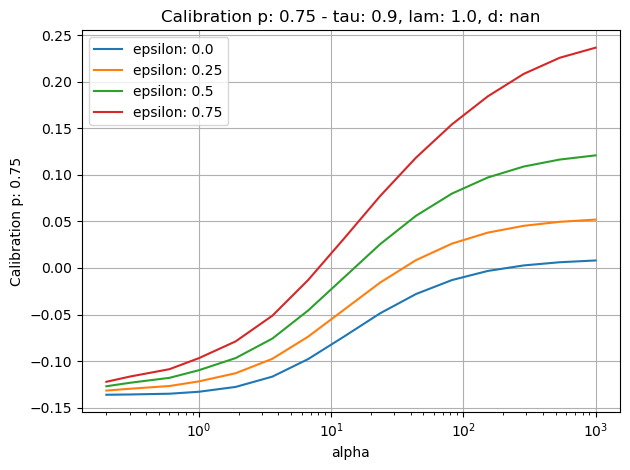

In [1085]:
# subset df to keep only where p = 0.5
p = 0.75
dfp = df[df.index.get_level_values("p") == p]
# remove epsilon = 1
dfp = dfp[dfp.index.get_level_values("epsilon") != 1]
create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False,log_x=True)
# erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


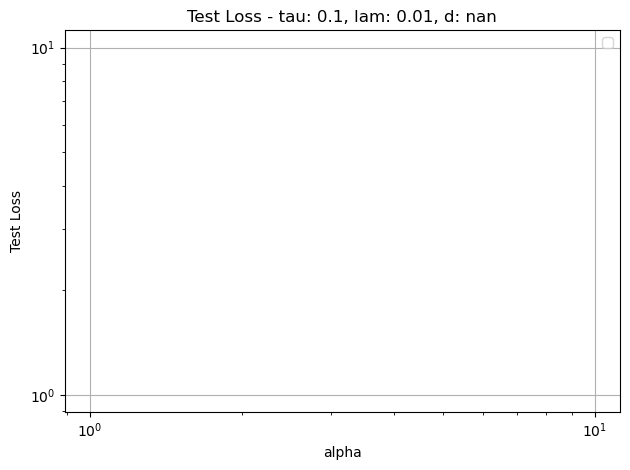

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


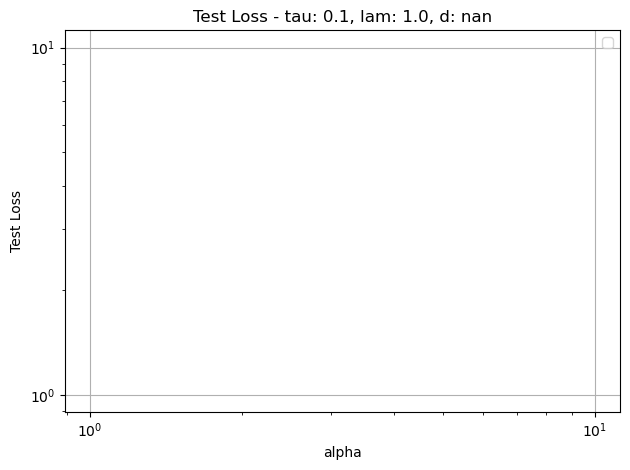

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


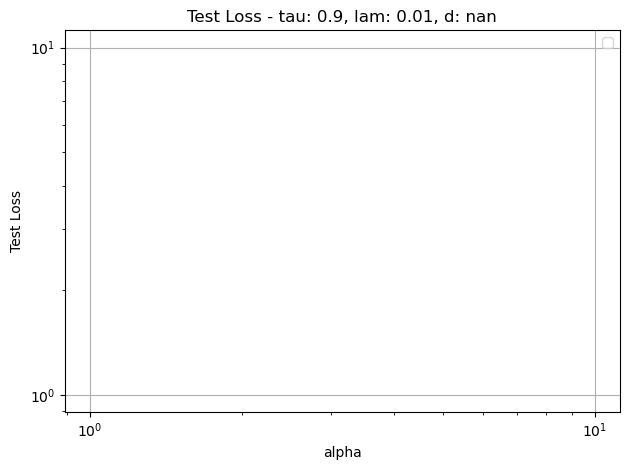

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


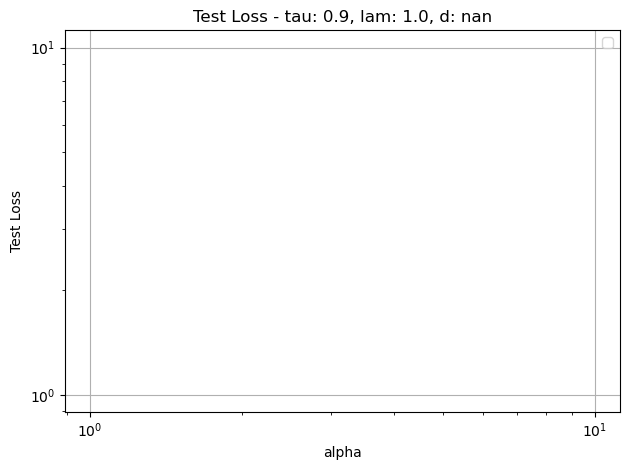

In [1086]:
# plot test loss erm
create_plot(df, "Test Loss", None,"test_loss_erm",log_y=True)

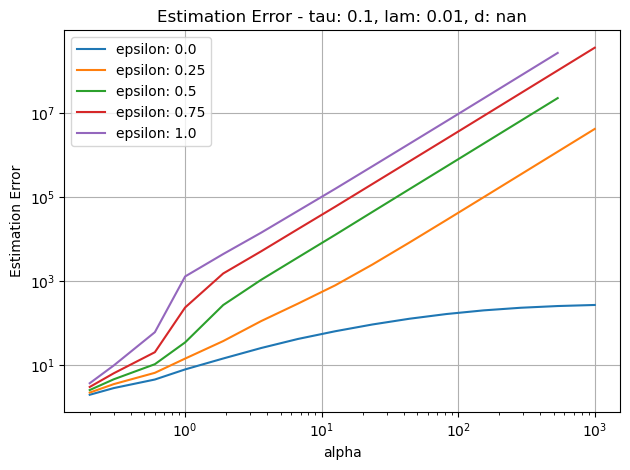

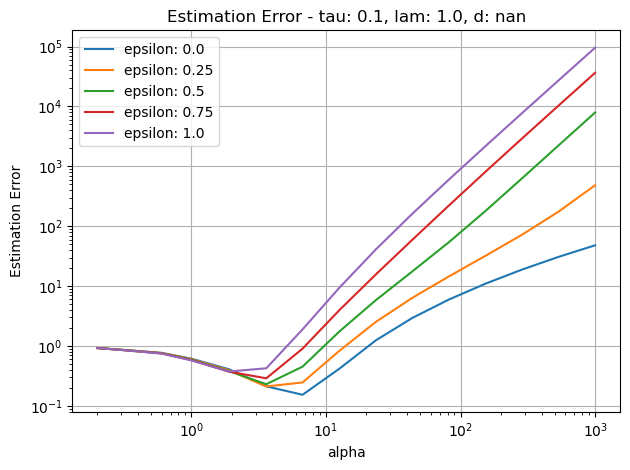

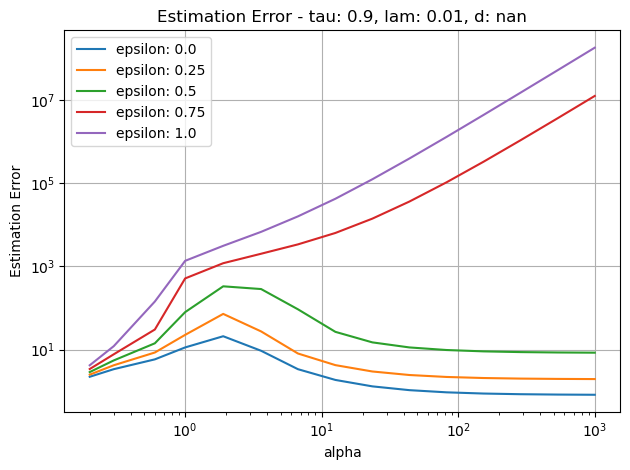

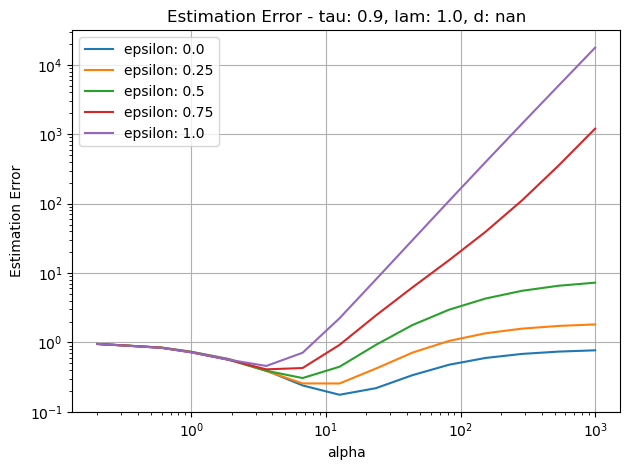

In [1087]:
# plot estimation_error_state_evolution
create_plot(df, "Estimation Error", "estimation_error_state_evolution",None,log_y=True)

## Log-Log Plots of overlaps in State_evolution

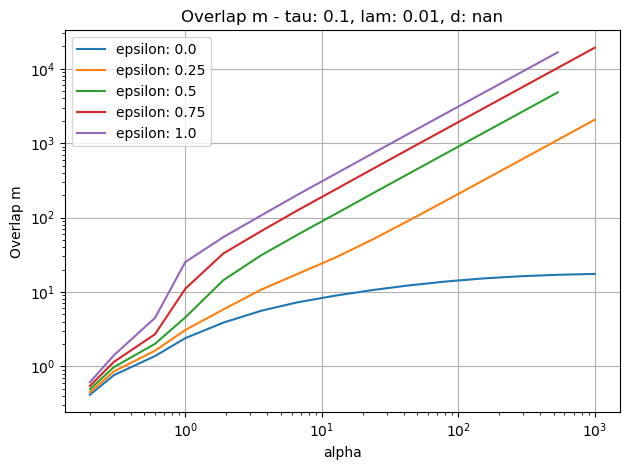

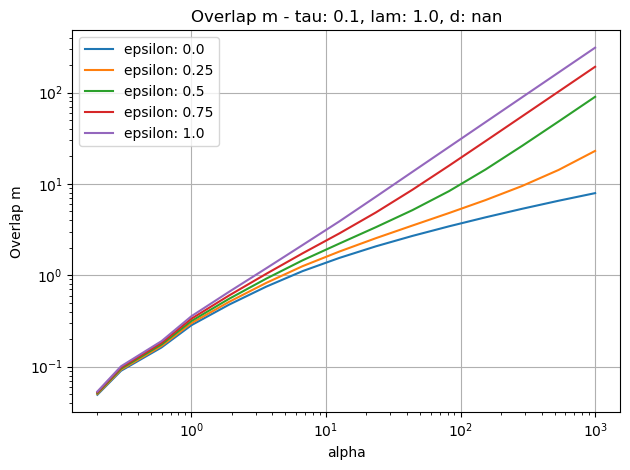

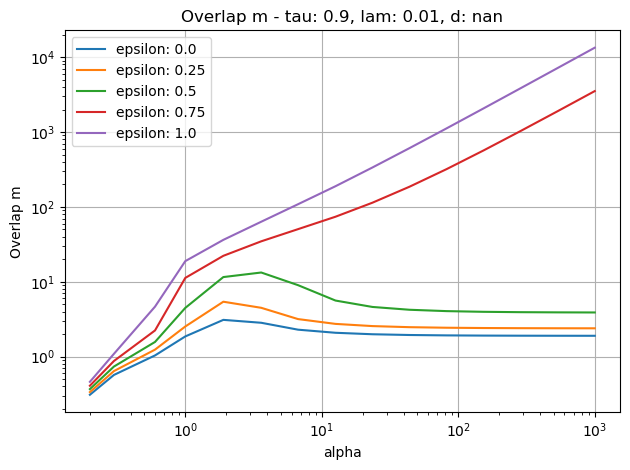

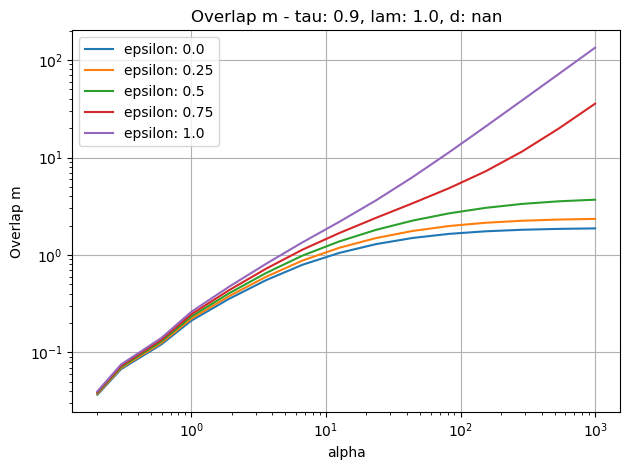

In [1088]:
# create a log-log plot of the overlap m
create_plot(df, "Overlap m", "m_state_evolution","m_erm", log_x=True, log_y=True)

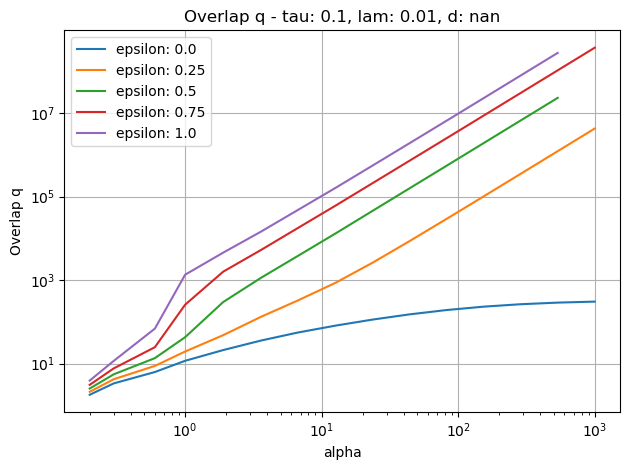

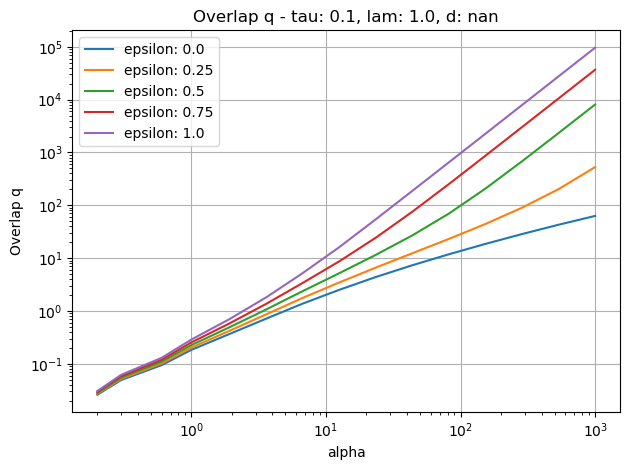

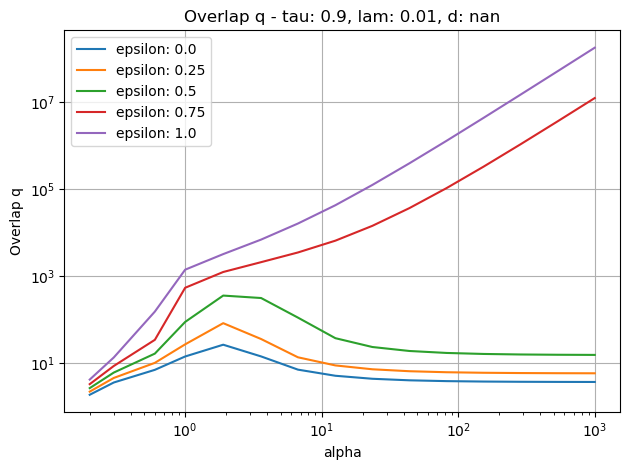

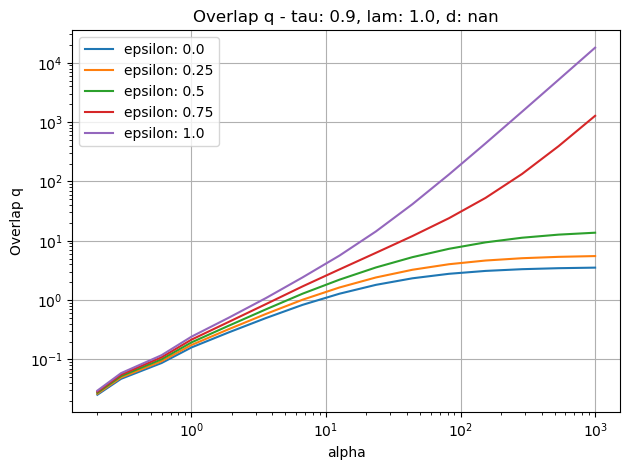

In [1089]:
# create a log-log plot of the overlap q
create_plot(df, "Overlap q", "q_state_evolution","Q_erm", log_x=True, log_y=True)

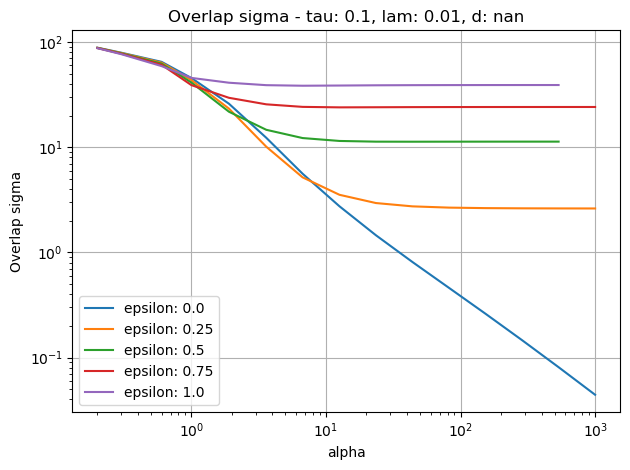

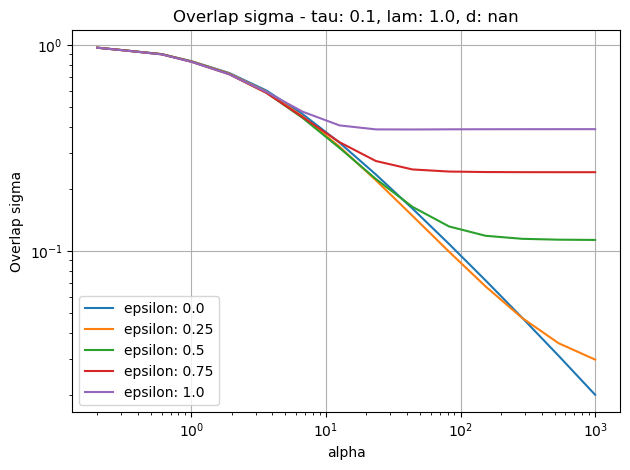

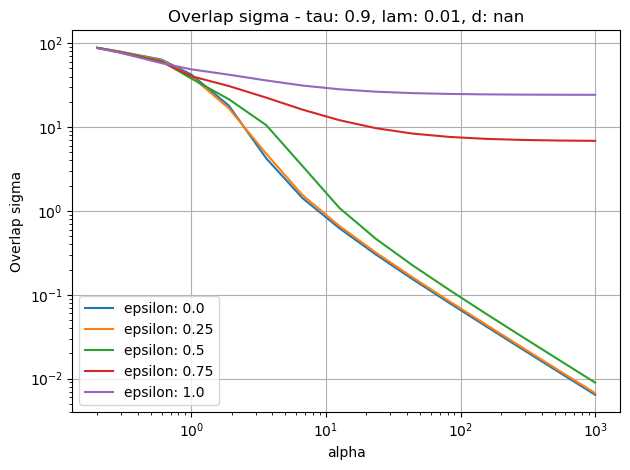

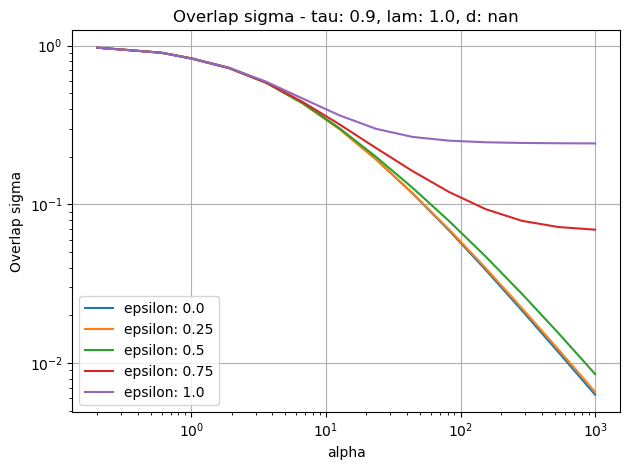

In [1090]:
# create a log-log plot of the overlap sigma
create_plot(df, "Overlap sigma", "sigma_state_evolution",None, log_x=True, log_y=True)

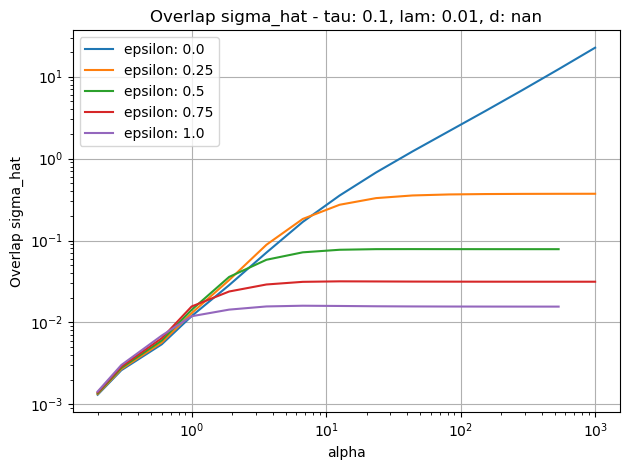

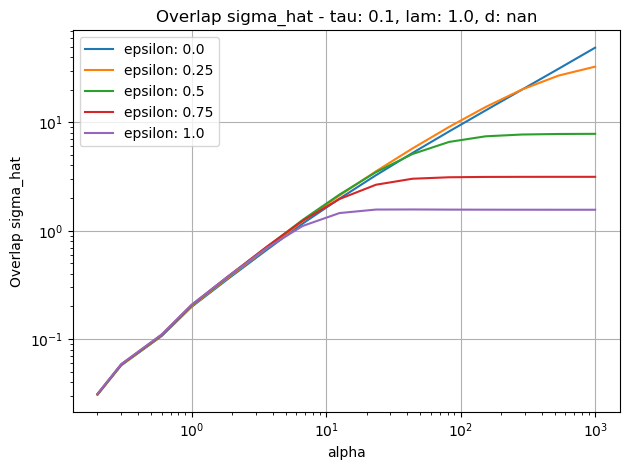

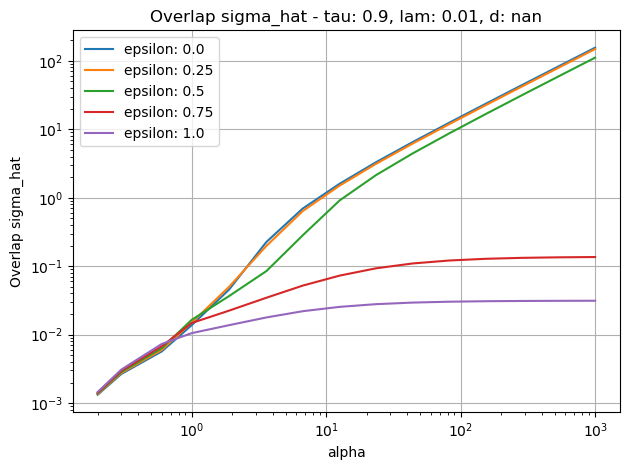

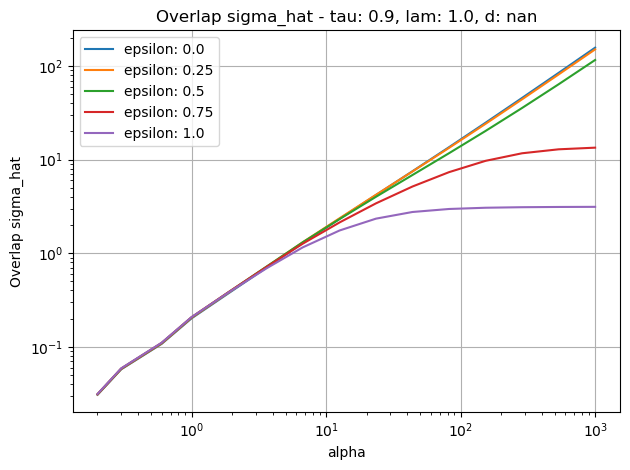

In [1091]:
# create a log-log plot of the overlap sigma_hat
create_plot(df, "Overlap sigma_hat", "sigma_hat_state_evolution",None, log_x=True, log_y=True)

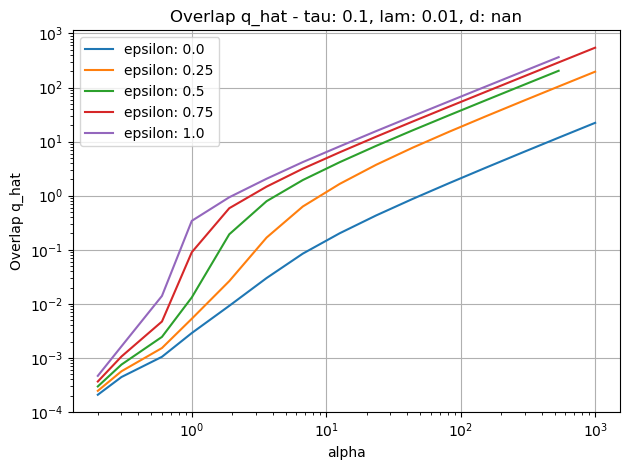

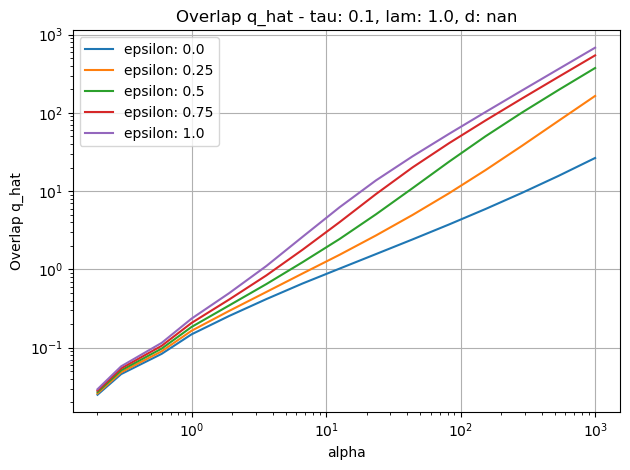

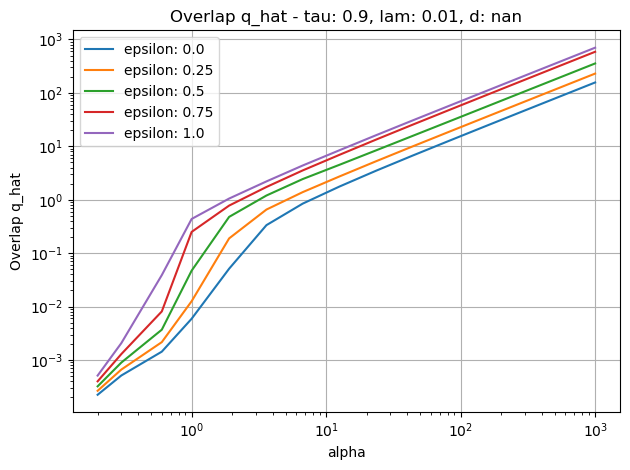

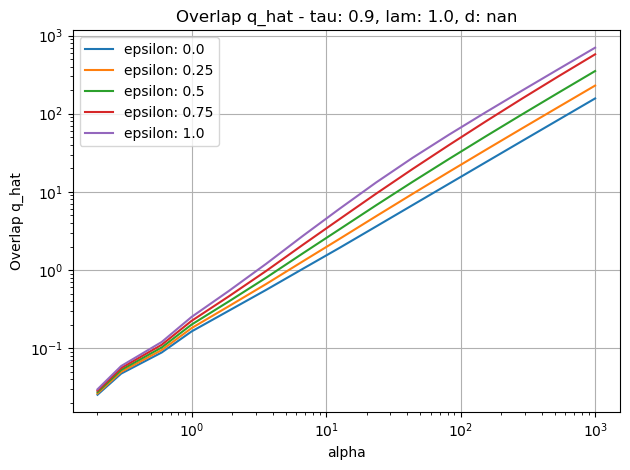

In [1092]:
# create a log-log plot of the overlap q_hat
create_plot(df, "Overlap q_hat", "q_hat_state_evolution",None, log_x=True, log_y=True)

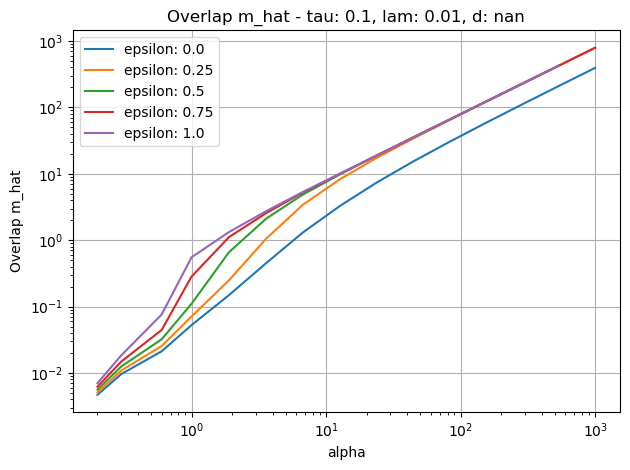

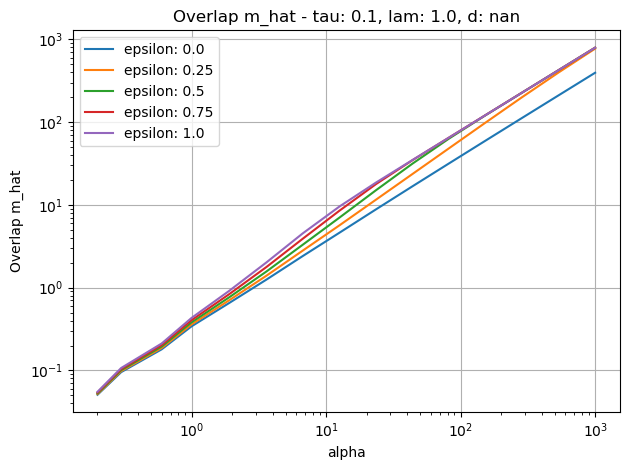

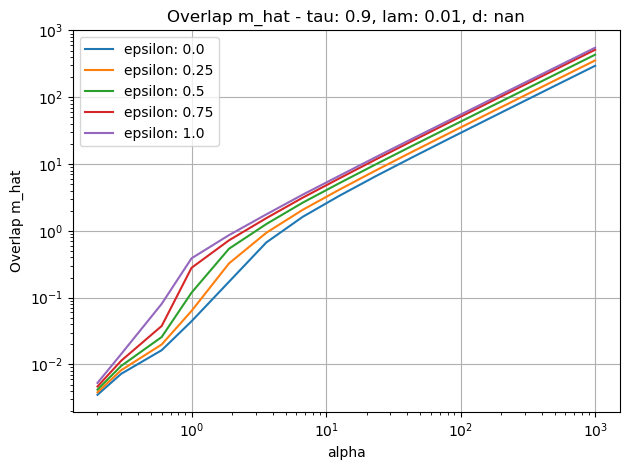

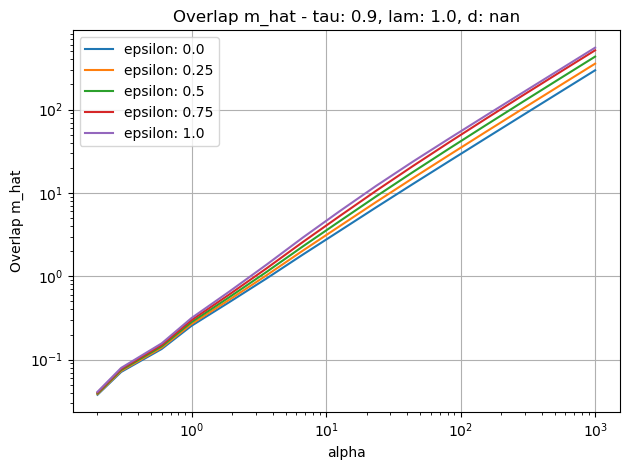

In [1093]:
# create a log-log plot of the overlap m_hat
create_plot(df, "Overlap m_hat", "m_hat_state_evolution",None, log_x=True, log_y=True)

In [1094]:
# # Create a SweepExperiment
def get_default_experiment():
    state_evolution_repetitions: int = 1
    erm_repetitions: int = 0
    alphas: np.ndarray = np.logspace(-0.8,1.2,5)
    epsilons: np.ndarray = np.linspace(0,1,3)
    lambdas: np.ndarray = np.array([0.01,1])
    taus: np.ndarray = np.array([0.1,0.9])
    ps: np.ndarray = np.array([0.75]) 
    dp: float = 0.01
    d: int = 700
    erm_methods: list = ["sklearn"]
    experiment_name: str = "Default Experiment"
    experiment = ExperimentInformation(state_evolution_repetitions,erm_repetitions,alphas,epsilons,lambdas,taus,d,erm_methods,ps,dp,experiment_name)
    return experiment
experiment = get_default_experiment()
# # use json dump to save the experiment parameters
with open("experiments/sweep_experiment_test.json","w") as f:
    # use the NumpyEncoder to encode numpy arrays
    json.dump(experiment.__dict__,f,cls=NumpyEncoder)